In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serial
import threading
import time
from traceback import print_exc

### Arduino serial communication

Defaults to: `SERIAL_8N1`, which means 8-bit, no-parity, 1-stop bit.

In [3]:
baud = 9600
addr = '/dev/cu.usbmodem1421' # or whatever

In [2]:
port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
# these are the default values anyway, but here they are set explicitly
# timeout should be set in order to work in a non-blocking mode

SerialException: [Errno 2] could not open port /dev/cu.usbmodem1421: [Errno 2] No such file or directory: '/dev/cu.usbmodem1421'

In [3]:
port.readline()

b'--Arduino ready.\r\n'

In [4]:
port.write(b'1')

1

In [5]:
port.read(1)

b'1'

In [6]:
port.read(1)

b'\r'

In [7]:
port.read(1)

b'\n'

In [8]:
port.close()

In [10]:
type(port)

serial.serialposix.Serial

In [4]:
# let us split the reader functionality as a thread

class SerialReader:
    port_ = None # serial I/O
    callback_ = None # callback function upon reception
    runner_ = None # the thread that waits for input
    signal_ = None # the event object that the 'runner' thread watches
    ready_  = False # whether or not it is ready to run.
    
    def __init__(self, port, callback=None):
        self.port_ = port
        self.callback_ = callback
        self.runner_ = threading.Thread(target=self._run)
        self.signal_ = threading.Event()
        self.ready_  = True
    
    def signal(self):
        """signals that the thread should terminate."""
        self.signal_.set()
    
    def start(self):
        """starts its internal thread."""
        if self.ready_ == False:
            self.reset()
        self.runner_.start()
    
    def _run(self):
        """the actual routine that is called only once from its internal thread."""
        print("SerialReader: start reading...", flush=True)
        callback = self.callback_
        while not self.signal_.is_set():
            c = self.port_.read(1)
            if (len(c) == 1) and (c != b'\x00') and (callback is not None):
                callback(c)
        print("SerialReader: end reading...", flush=True)
    
    def join(self):
        """joins the internal thread."""
        if self.runner_.is_alive():
            self.runner_.join()
    
    def reset(self):
        """resetting the state of the thread."""
        if self.runner_.is_alive():
            # within 'run' method
            self.signal() # set event anyway
            self.runner_.join()
        self.signal_.clear()
        self.runner_ = threading.Thread(target=self._run)
        self.ready_  = True

In [96]:
def testcallback(c):
    if c not in (b'\r', b'\n'):
        print(">>> {}".format(c))

port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
reader = SerialReader(port, testcallback)

In [97]:
reader.start()

SerialReader: start reading...


In [98]:
port.write(b'1')

1

>>> b'1'


In [100]:
for c in "abcdefghijk":
    port.write(bytes(c, 'ascii'))

>>> b'a'
>>> b'b'
>>> b'c'
>>> b'd'
>>> b'e'
>>> b'f'
>>> b'g'
>>> b'h'
>>> b'i'
>>> b'j'
>>> b'k'


In [101]:
reader.signal()
reader.join()

SerialReader: end reading...


In [102]:
port.close()

Now try building a test.
1. Wait until Arduino says 'ready.'
2. Write a byte every now and then, keeping notes of the time.
3. Read the output from Arduino and store the time.

In [46]:
ord(b'1')

49

In [53]:
bytes(chr(49), 'ascii')

b'1'

In [139]:
class IOTest:
    """runs I/O test on a serial port using the specified charset."""
    
    def __init__(self, charset):
        self.charset_ = [ord(c) for c in charset]
        self.writer_ = None
        self.reader_ = None
        self.nread_ = None
        self.port_ = None
        self.interval_ = 1.0
        self.number_ = 1
        self.timings_ = None
    
    def run(self, port, interval=10, N=1000):
        """runs the test with a serial object being at 'port'.
        
        Parameters
        ----------
        
        port -- serial.Serial() object that has been already created.
        
        interval -- the (nominal) interval in milliseconds at which each byte is sent.
        
        N -- the number of byets to be sent.
        
        Returns
        --------
        
        timings -- an (2, N) numpy array that has times of transmission ([0,:]) and reception ([1,:]) in it.
        """
        self.port_ = port
        self.interval_ = interval/1000
        self.number_ = N
        self.timings_ = np.empty((2,N), dtype=float); self.timings_[:] = np.nan
        self.writer_ = threading.Thread(target=self._count)
        self.nread_ = 0
        self.reader_ = SerialReader(port, callback=self._input)
        
        self.reader_.start()
        self.writer_.start()
        self.writer_.join()
        self.reader_.join()
        
        return self.timings_
    
    def abort(self):
        if self.reader_ is not None:
            self.reader_.signal()
            self.reader_.join()
    
    def _count(self):
        """actual method for writing to the serial port, which is called from the internal thread."""
        try:
            interval = float(self.interval_)
            number = int(self.number_)
            counter = 0
            
            chars = np.random.choice(self.charset_, size=number, replace=True)
            print("IOTest: starting writing bytes...", flush=True)
            while counter < number:
                time.sleep(interval)
                self.port_.write(bytes(chr(chars[counter]), 'ascii'))
                self.timings_[0,counter] = time.time()
                counter += 1
            print("IOTest: ending successfully...", flush=True)
        except:
            print_exc()
            print("IOTest: aborting.", flush=True)
    
    def _input(self, c):
        """the callback method for SerialReader."""
        if c not in (b'\r', b'\n'):
            self.timings_[1,(self.nread_)] = time.time()
            self.nread_ += 1
            print(c.decode('ascii'), end='', flush=True)
            if self.nread_ == self.number_:
                self.reader_.signal()

In [181]:
def run_test(addr, baud, interval, N=1000):
    test = IOTest((b'A', b'B'))
    port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
    time.sleep(2)
    try:
        print(">>> " + port.readline().decode('ascii')) # waits until it sends a line back

        result = test.run(port, interval=interval, N=N)

        result -= np.nanmin(result, axis=1, keepdims=True)

        fig = plt.figure(1)
        plt.title("baud={}, interval={}msec, N={}".format(baud, interval, N))
        plt.plot(result[0,:], result[1,:], 'k-', lw=2, label="reality")
        plt.plot(result[0,:], result[0,:], 'k--', lw=1, label="ideal")
        plt.xlabel("time sent (s)")
        plt.ylabel("time received (s)")
        plt.legend()
        return fig
    except:
        print_exc()
    finally:
        port.close()

>>> --Arduino ready.

SerialReader: start reading...IOTest: starting writing bytes...

BBAAABBBBABBBBBBAABBABAAABBAAAAABBBABBAABABBBBAABBBABAAAAABBBAAAABAABABBABBBBAABABBABBABABAABAAAABAABBAAABBBBAABABAABAABBAAAAAABAAAAAABBABBBBBBBBAAAAABABBAABABBBBBAABBBAABAAABBBBABBBBBBBAAAABBBBBBABABAABABABBABABBBBABBABBBABABBABBAABAABBBBABABBAAABAABBAAAABABAABABBBAAAIOTest: ending successfully...
BBBAAAAAABABBBBABBBAABABBAAAABABABBAAAABABBBABAABBBABAAAABAAAAAAAAABABABABBAAAABAABBABAABAAAAABBBAAABABBBBAABBBABBAAAABABAAABABBABABBBABBABAAAAABABBBBAAAABBAAABAABBBAAABAABABBAABBBBBBBBBBAABABABABABAAABBAABBBBABBBBBBAABABBAAABBAABBBBABBAAABBAABABBBBABBABAABBBABBAABAABBBAABBABBABBBBBAABAAABBBBABAABABBBAAAAABAAABBAABBBBBBABAABBBBABABBABBAABABABBBABBAABBBBAABABABBBBABBBAAAAABBBBAAABBBBAAABABAAABBABABAABAAAAABAAABBBABBBAABBBABABBBBAABBABABABBBBBBBBBABABABBBBAAAAABAABABAABBAAAABBAABBABBBBAABABAAAAAABBABAAABBABBABAAAAAAABABABBBABBBABBABBABABAABBAABBAABBAABBAABBBBABABBABABABBBABBABABABBAABABBAAABABBAAAAABBABBABAB

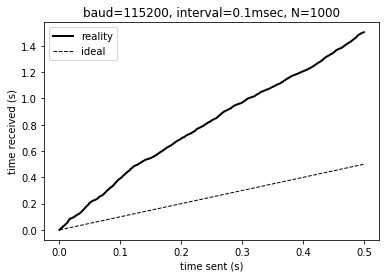

In [182]:
run_test(addr, 115200, 0.1)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BABAAABAAAAABAABAAAABBAAABABBABAABAAABABBBBABBBAAABAABAABBABABABAAABBBBBBAAABAAAABBBAAABAAAAAABBAABAAAAABBABAABABAABBBBBAAAAABAAAABAABBABABABBBBAABBABAAABBAAABABBBBBAABAABBBAABABBBBBBAABBBBABAABABBBBBBBAABBBBABAAAAAABBBBAAABBAABAABABBAAAAABAABBAABABBBAABBABBAAAABBBABBAABAABBABBABBABAAAAABABBBBAAAABAABBAABBBBAAAABABAAABABBABBBBAABBBAABBIOTest: ending successfully...
ABBABBABBABBBABBBABBBABABABAAAAAABBBAAAABABBBABABBABBABBBBAAABAAAAAABAAAABBAABABAABBBABBABBBAABBBBAABBBBAABABABBABBBBBBAABBAAAABABABBBAABAABAABABBABABBBABABBBABBBBBBBBABABBBBBBBAAAABBABBBABABBBABAAAABAAABAAAABAAABAABBBABBABAAABBBBAABAAAAAAAAAABBBAAAAAABBBBBAAABABAABBBAAAAAAAAABAABBBAAAAABABAABBBABABBABAAAAAAABBAABBBBABBAAABBAAABBABABBBABAAAABAAABAABBBBABBBAABBBBBBABBBAABAAAABAABABABABBBABABBAABAAABBABBBBBAABABBBABBAABABAAABBBABAABBABABABBBBABBBABAAABBBAAAABBABAAAABABABBAAABBABABAAAAAABAAABBABBAABABBBBAAABBBABBAABBBBBBAABAABBBBAABABBAAAABAA

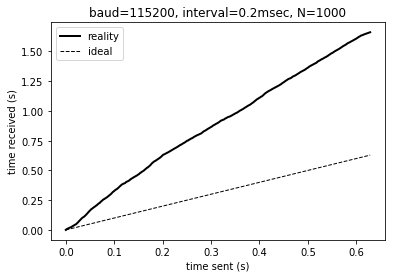

In [183]:
run_test(addr, 115200, 0.2)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BABBAABABABAAABBBBAAAABBAABAABBBAABABAABBBBBBABBBBABBAAAAABAABBBAAABAAABABBBABBBABBBBABAABBAAAABBBAAABBBABAAABABBABAABBBAABABBBBBAAAAABBBBBBBBABBAAABBBABBBBBBAABBBBBABBBBABBAAAAAAABBABBBBBBAAAABBABBABABBABAABBABAAAABBBABBBAAABAABAABBAABBBBAAABBBBBBABBABABABBBABBBBAAABBBABBBABAABAABBABABABBBBBAABBBBBABABABAAAAAABBAAABBBABAABAABAAAABBBABBBABBBABABABABBABABBABAAAABAABABBBBAAAAAABBAABBAAAAAABBBABAABBAABBAABAABBBAABBABAABABBBABAAABAABABBABABABABABABBAABAABBBAABBABBAABAABAABABAAABBBBABBABABBABABBBABBBAAABABBAAAABBBBAAAABBABBBBAAAABAIOTest: ending successfully...A
BBBAAAAAABAAABBBBBBABBBAAAABABAABBAABAABBAAAABBABABAABBBBBABBBBABBBBBAAABABBABBABBABABAABBBBABBABABABBAAAAAABAAABBAAAAABABAABBABABBAAAABABAAAABBABBABBAAAAAAABBAABBBAAAAABBBABAAAABABBBABBAAABBABBBBBAABABABBBBBBBAABBBABABBAABAABBBBABBABBAAAABABBAAAAAABAAAABBBABBAABBAAAAABBBABABABBBAABAAABABAABAABABAABBBAABABBAABBAABBABBABBBABABBAAABBAABAABABABBAAAAA

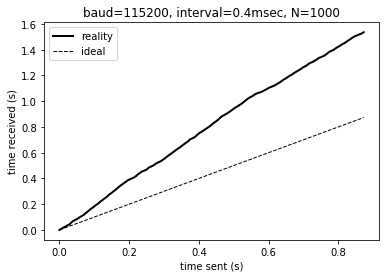

In [210]:
run_test(addr, 115200, 0.4)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BBBABBBBBAAAAAABBBABAAAAAABBABAAABAABBAABAABBAAAAABABABBABBABAAABBBABAAAABBABAAAABBBBBAAAABBBAAAAAAABBABABAABBBABABABAABABBBABBBABABABBABBAAABABABABBBBBAABAAABAAAABBAABABABABABBABAAABABBAABAABABABBAABBAAAAABAABAABBABABAAABABAABBAABABABAABABAAABAABBBBBBBABBBABABABBBAABBAABBAAABBABABBAAABAAAAABBAAAABABABAAAABABBABABAABBBBBAABBAAAABBABABBBABAABABBBAAAABAABBBBAABBBABBABAAABBAABBABBBABAABBABABABAABABABAABBABABABAABAABBBAABBABBAABABBAABAAAAABABAAABBAAABABAAAABABABABBABABBBBBBBABABABBAAAABBBABAAAABABABBABBBABBBAABBAABAAAABBABABABBBABABBBAAAAAAABBAABBAAAAABABAAAAAAABBAAABAAAAABBABBAABBAABBAAABAAAABAAAABAABABBAABAABBBAAAAABAABBBBBABAAAABBBAABBBAABBAABAAAAABABAAAAABABABAAAABAABABAABAABBABBBBBABBBAAABAAAABBBBAABBABABABBBABABBAAAABAABABBAAAABAAABBAAABAABAAABBAAAABABBBAABABAAAAABBAAABABAABAABBAAAAAABABABABBAABBBBBAAAAABABAAAABABBBIOTest: ending successfully...
ABBAABAABBBBBABBABBABBBABBBAABBABBBAAABABAABABBBBBBAA

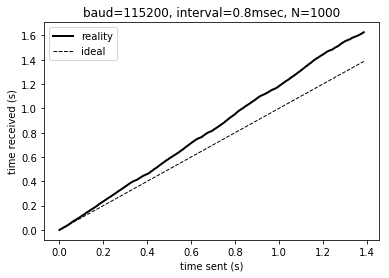

In [185]:
run_test(addr, 115200, 0.8)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ABBBBABABBAAABBBBAABBAABABAAABAABBBBBAAABBABABBBAABAABBAAABAABBBAAABAAAABBABBAABAABABBBBABBABAAAAABAAAAAAABBAABBBAABBBBAAAABBBABBABAABBAABBBBBBAAAAABABBBBAAABBBAAAABBABBBBAAAAAABBBBABABBBBBBBBBABBBAAABBAABAABBAABBAAABBAAABBAABBABAABAAAABBBAABBBBAABAAABBABABBBAAAAAAAABAABABBABAAABABBABAAABAABABABABABAAAABBABBABBBBBBAABAAABBBAAABAABBBBBABAABABABABBABBABBABBABBBBBABBAAABABABAAAAAABBBBBABABBBBBBABBAAABABBABAABAABAABABBBBABBBABABBABBBBAAABAABBBAAAABBABABABBABABAAABBABBABBBBAABABBABBABABAABBABBAABBABBBBBABAAABABBABBAABBBBBAAAABAABAAAABBAABBBAAABBBBABBBAAAABABAAAABBBBBBABBBBABABBABABAABBBABBAABBBBABAAABAABAABBAABAAAAAAABAABBABBBABABBAAABBAABAAABAABBBBABBABBBAAABBBABAAABABAABBBBBAABABBABABABABBBAAAAABAABBABABABABAABBBBBBBBBBBAAAABBABABABBBBAABAABBBBBBABAABABABAAABAAAABBBABBBBBAAAAABABBBABAAAABABABBABABAABBABAAABBABABBBBBBAAABABABABBBABBABABAABBABAAAABBABABBABBBAAAAABABAABABBAAAABABBBABBBBABAABABBBAABBABABABA

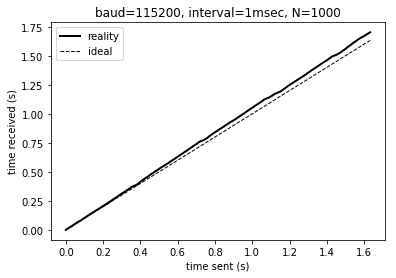

In [186]:
run_test(addr, 115200, 1)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BAABABBBAABAAAABABABAABBAAABBBBBBBAABABABAABBBBABABABABAAAABAABAABAAABBBBABBBBBBAABAAAAABBAABABAABBBABAAAAAABBABAABABAABBBBBABBAAAABBBAABBBAABBBBBABAABBBBABABBBBBAAABABBABAAABBBBAAABABAAAAABABAAABBABAABABAAAAABABBBBBBABABABABAABABBABABBBBBAAAABABAABBBABABBAAABAABBBABBAAAAAABBBBBBBAAABAABBAABAAABBAABAABBABBBABAAAAABAAABBBBBBBBBBAAABABABABAABBAABBBBBABABAABAABBBBAABBBABAABABABBABABBBABABBAABBABBAAABABBAABBBAAABABBBABAAAAABBAABBBBBBBBBBBABBAAAAAAABABBAAABBABABAAAAAAABAAABBBBBBAAABAAABAABAAABBBABABBBBABBBABBBBBABBBABABBBABBAAABAABBAABAAABAAAAABABAABABBBAAAABBBBABBAABAABAABBBBAABAABBBAABBBBAABABABBBABABABAAABAABBAABABABAAAABAABBBABBBBBBABABBAABBABBBBBBABBAAAAAAABAAABBABBBBBABBABABBBABBBBBABABAABBBBBAABBABAAAAABBBBAABAABAABAAABBAAAAAABABAAAABABBBBAAAAABAAABAAABABBBAABAABABBABAAABBABAABAABABAABBAAAABAAABAABBBAABBBBBBBAABABBBBABABABAABBAABBBABBABBBAAAABAAAAABBBBBAAAABAABBBAAAABBAABBAAABBBBABBBABBAAAABABBBABA

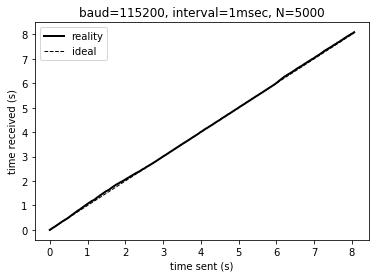

In [187]:
run_test(addr, 115200, 1, N=5000)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BABBBABBAAABABAAAAABABBBBABABBAAAAAABABAAABBAAAAABAABBBBABAAAABABBABABBBBBBBABBBBABAAAABABBAAAAABAABBBBABBBAAAABBAABBABBBABBABBBBBBABAABABABBBBABBBABABAABBBABBAAAABBBBBBAABAABBAAABABBAAAABABABBAABBBABAABAAABABABBBBBAABABAAAABABABBAAABBBAAABBBBBABBBBABBAAABBBAAABABABAABAABBBBAABBAABABBABBBBABBBABBABBBBABABBBBBAABABBBAAABABBABBABBBABBABBBBAABABBAABABBABABAAABBBBABABBABBBABAAABAAABABBBAAAABABBABAABABBBBABAABBAAAAAAAABBAABBABBBBABABABBBBAAAABAABBABBBBAAAABABBABBABAABABBABAABBABAABABBABAAAABAAABBABBAABBAABABBAABBBBABABAABBAABBABBBAAAABBABAAABBBBABBBBAAABABAAABBBBBABBBBBAAAAABBBBBBBBAAABAAABBABBBBABBBABAAABABAAAAAABBAAAABAABBBBBBBABBABBABABABBBABAAAABBABBABABBBAABAABBBAABBBAAABBABBBBABBAABABBABAABABABBAAABAAABBBAAABABABAAABAAAAABBBAAABAAAAABBABBABAABABBABAABABBBBBBABBBBBBABAABAABAAABAABBABABABABBBAAABBABBAAABAAAAABAAAAAAAABABAAABABBBBAABAAABBABBAABBBBBBBBAABAAABABBABBBAABBAABABBAABAAAAAABBAABBBBBBAAABBBBAB

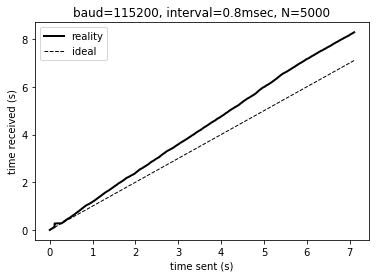

In [188]:
run_test(addr, 115200, 0.8, N=5000)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...IOTest: starting writing bytes...

BAAABBBABABAABBABBABBABBAABABABAAABAABAABBAABAAABBBBABABBBABAAAABBBBBBBABBAAAAABBAAABBABBABABABBABABBBABBAABBABBBAAAAAABBBAABABABBABAABABBABBAAAABAABBABBAABBBAAAABAABAABABABAABBABBBAAABBBAABBBBBBAAABBABBBABBAAAABAABBBBABAABBBAAABABABBBBBBBBABBBBBAAABABABBBBABBBBBABBAAAAABAIOTest: ending successfully...
BBAABBBAAABAAABBAAAABABBBBBBBBBBBBBBABBBBABABBAABBABAAAABBBABBBABAAAAAAAAABAABBBAAABBBBBAAABBBABBBBBBABAAABBBBBABBABBBBABBABBBBAABAABBBAABBAAABAABBBAABABABBABAAABBBAABBABBAABBAABBBBABBAABBBABBAAABBBBABABBAAAABBBAAABBAABAABBAABABBBAAAABABBAABBBAAAAABBAAAAAABAAABABBABBBABABABAABABBBAAAAAABABBBBABBABABBABABABBBBAAAABABBAAABBBBBAAABBABBBAABBBABABBBBAABAABBABABAABBBAABAABAAABBBAAAABBBABAAABABAAAABAABABBBBABBAAABBBAAABBBAABBBBAABAABBAABBABABAAABAAAABAAABBAABAABAABBBBBBBBBAABBBABBAAABAABBBABAAABBBABBBAAABABABABBBAAAABAABAABBABAABABAABAABABBABABBBBAABABBAABAAABABAABAABAAAABAAABBBABBAAABBABABBABABABABBABBBABABA

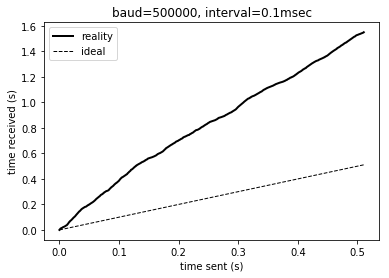

In [173]:
run_test(addr, 500000, 0.1)
plt.show()

The results above strongly indicates that this delay is due to processing between Arduino (either the serial-USB chip or the AVR chip itself, or this computer...?).

I try optimizing the communication...

>>> --Arduino ready.

SerialReader: start reading...IOTest: starting writing bytes...

BAAAABBBAAAAAABAAAAAABAAABAAAAAABAABABAABBABAAAABBBBABAAAABBBABABAAAABABABBAAABABBBABABBAAAAABBABBBBAAABBABABBBBBABBBABBABAABBBABBBABBBAAABBBAAABAABBABAAABBABAABBAABAABABBABABAAAAAABBBBBBBAABAAABBBBAABBBAAABABAAAAABAAABABBBBABAAAAABAAABABBAABBAAABABBABBBABABBBBBBBABABABBABBBABBBBABBAAABAAABBBBAIOTest: ending successfully...
AABAAAAAABBBBBABABAAABBABBAAABAAABAABBBABBAABBABBABAABBBBABABBABBAABABAABABAABAABBBABBAAAABBBBABAABBBBBBBBBAAABAABAABAAABBBABABAABABABABABAAABAAABAAABBBABAABABBABBABABBAAAAABBAAABBBAABABBAABAAAABABBABBBABBBAABABABBAABBBBBABABABABBABBBBBBBABBAABBBBBABBABBBBABAAAABABABBABAABBBAABBBBBBAAABABBAABBBAABAABABAABABAAAABBABABBBBBAABBABBBAABAAABABAABAAAAAAABBABBBABABBABBBBBABABBBBAABAABAAABBBAABBABBABBBAABAABABBBBBAABABABAAABABBBABBABBABBBABAABABBAAAAABAABABBBBBABBABABBAAABAABAABAABAAABBBBABABABAABAABBAABABABBABBABBAABBBABBAAAABABABAAABBAAAAABABBBABABABABBBBBABAAAABAAAABABBBABAABAABABBAABAB

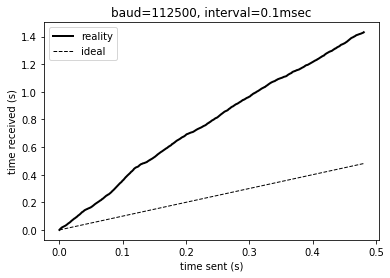

In [174]:
# removed \r\n
fig = run_test(addr, 112500, 0.1)
plt.show()

So removing newline characters (i.e. compressing the I/O to half) does not help in reducing the latency. Likely the hardware problem on Arduino (or serial stack problem on Mac).

Current possible solutions are:

1. Reduce redundancy from the output byte sequence (i.e. BAAABBBA -> BA..B..A, with '.' not being sent).
1. Try to avoid having $<1$-msec bins (i.e. by changing update frequency from the camera).

In [3]:
# Try the first solution

class IOTest2:
    """runs I/O test on a serial port using the specified charset.
    it takes care of redundancies.
    """
    
    def __init__(self, charset):
        self.charset_ = [ord(c) for c in charset]
        self.writer_ = None
        self.reader_ = None
        self.nread_ = None
        self.nwritten_ = None
        self.donewriting_ = threading.Event()
        self.port_ = None
        self.interval_ = 1.0
        self.number_ = 1
        self.timings_ = None
    
    def run(self, port, interval=10, N=1000):
        """runs the test with a serial object being at 'port'.
        
        Parameters
        ----------
        
        port -- serial.Serial() object that has been already created.
        
        interval -- the (nominal) interval in milliseconds at which each byte is sent.
        
        N -- the number of byets to be sent.
        
        Returns
        --------
        
        timings -- an (2, N) numpy array that has times of transmission ([0,:]) and reception ([1,:]) in it.
        """
        self.port_ = port
        self.interval_ = interval/1000
        self.number_ = N
        self.timings_ = np.empty((2,N), dtype=float); self.timings_[:] = np.nan
        self.writer_ = threading.Thread(target=self._count)
        self.nread_ = 0
        self.nwritten_ = 0
        self.donewriting_.clear()
        self.reader_ = SerialReader(port, callback=self._input)
        
        self.reader_.start()
        self.writer_.start()
        self.writer_.join()
        self.reader_.join()
        
        return self.timings_
    
    def abort(self):
        if self.reader_ is not None:
            self.reader_.signal()
            self.reader_.join()
    
    def _count(self):
        """actual method for writing to the serial port, which is called from the internal thread."""
        try:
            interval = float(self.interval_)
            number = int(self.number_)
            counter = 0
            prev = None
            
            chars = np.random.choice(self.charset_, size=number, replace=True)
            print("IOTest: starting writing bytes...", flush=True)
            while counter < number:
                time.sleep(interval)
                if chars[counter] == prev:
                    pass
                else:
                    self.port_.write(bytes(chr(chars[counter]), 'ascii'))
                    self.timings_[0,self.nwritten_] = time.time()
                    self.nwritten_ += 1
                    prev = chars[counter]
                counter += 1
            print("IOTest: ending successfully: written {} bytes".format(self.nwritten_), flush=True)
            self.donewriting_.set()
        except:
            print_exc()
            print("IOTest: aborting.", flush=True)
            self.donewriting_.set()
    
    def _input(self, c):
        """the callback method for SerialReader."""
        if c not in (b'\r', b'\n'):
            self.timings_[1,(self.nread_)] = time.time()
            self.nread_ += 1
            print(c.decode('ascii'), end='', flush=True)
            if self.donewriting_.is_set() and (self.nread_ == self.nwritten_):
                print("read {} bytes.".format(self.nread_))
                self.reader_.signal()

In [4]:
def run_test2(addr, baud, interval, N=1000):
    test = IOTest2((b'A', b'B'))
    port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
    time.sleep(2)
    try:
        print(">>> " + port.readline().decode('ascii')) # waits until it sends a line back

        result = test.run(port, interval=interval, N=N)

        result -= np.nanmin(result, axis=1, keepdims=True)

        fig = plt.figure(1)
        plt.title("baud={}, interval={}msec, N={}".format(baud, interval, N))
        plt.plot(result[0,:], result[1,:], 'k-', lw=2, label="reality")
        plt.plot(result[0,:], result[0,:], 'k--', lw=1, label="ideal")
        plt.xlabel("time sent (s)")
        plt.ylabel("time received (s)")
        plt.legend()
        return fig
    except:
        print_exc()
    finally:
        port.close()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
BABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABAIOTest: ending successfully: written 467 bytes
BABABABread 467 bytes.
SerialReader: end reading...


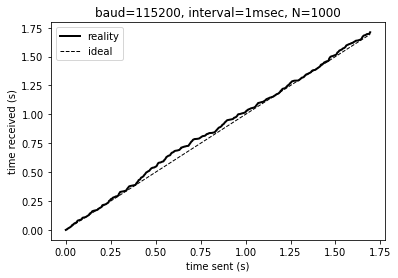

In [20]:
fig = run_test2(addr, 115200, 1)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABIOTest: ending successfully: written 519 bytesA
BABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABAread 519 bytes.
SerialReader: end reading...


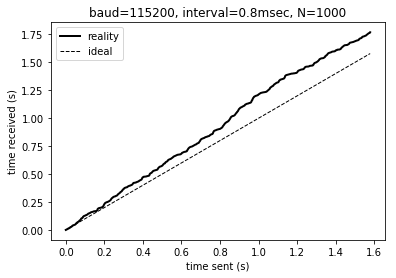

In [25]:
fig = run_test2(addr, 115200, 0.8)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABIOTest: ending successfully: written 509 bytes
ABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABAread 509 bytes.
SerialReader: end reading...


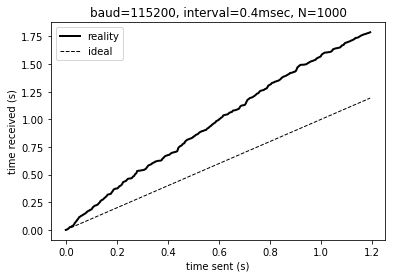

In [26]:
fig = run_test2(addr, 115200, 0.4)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABIOTest: ending successfully: written 512 bytesA
BABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABread 512 bytes.
SerialReader: end reading...


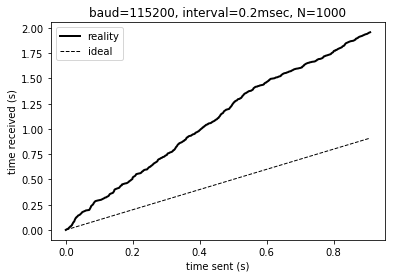

In [23]:
fig = run_test2(addr, 115200, 0.2)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABAIOTest: ending successfully: written 492 bytes
BABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABABread 492 bytes.
SerialReader: end reading...


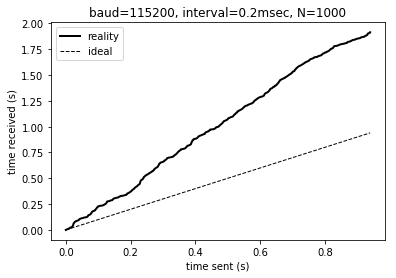

In [24]:
# without any processing in arduino
fig = run_test2(addr, 115200, 0.2)
plt.show()

In [30]:
ord(b'A')

65

In [10]:
a = int('10000101', 2)
a

133

In [44]:
a & ~0x2F

128

In [45]:
(a & 0xC0) >> 6

2

In [8]:
def decode_bits(i):
    """i: 0-2 integral, returns: 'N', 'S' or 'L'"""
    if i == 0:
        return 'N'
    elif i == 1:
        return 'S'
    elif i == 2:
        return 'L'
    else:
        return '?'

def decode_compressed(b):
    """b: a byte received, returns: 4 characters"""
    b = ord(b)
    ch  = decode_bits((b & 0xC0)>>6)
    ch += decode_bits((b & 0x20)>>4)
    ch += decode_bits((b & 0x0C)>>2)
    ch += decode_bits((b & 0x02))
    return ch

In [12]:
decode_compressed(chr(a))

'LNSN'

In [33]:
# output compaction

class IOTest3:
    """runs I/O test on a serial port using the specified charset.
    it takes care of redundancies.
    """
    
    def __init__(self, charset):
        self.charset_ = [ord(c) for c in charset]
        self.writer_ = None
        self.reader_ = None
        self.nread_ = None
        self.nwritten_ = None
        self.donewriting_ = threading.Event()
        self.port_ = None
        self.interval_ = 1.0
        self.number_ = 1
        self.timings_ = None
    
    def run(self, port, interval=10, N=1000):
        """runs the test with a serial object being at 'port'.
        
        Parameters
        ----------
        
        port -- serial.Serial() object that has been already created.
        
        interval -- the (nominal) interval in milliseconds at which each byte is sent.
        
        N -- the number of byets to be sent.
        
        Returns
        --------
        
        timings -- an (2, N) numpy array that has times of transmission ([0,:]) and reception ([1,:]) in it.
        """
        self.port_ = port
        self.interval_ = interval/1000
        self.number_ = N
        self.timings_ = np.empty((2,N), dtype=float); self.timings_[:] = np.nan
        self.writer_ = threading.Thread(target=self._count)
        self.nread_ = 0
        self.nwritten_ = 0
        self.donewriting_.clear()
        self.reader_ = SerialReader(port, callback=self._input)
        
        self.reader_.start()
        self.writer_.start()
        self.writer_.join()
        self.reader_.join()
        
        return self.timings_
    
    def abort(self):
        if self.reader_ is not None:
            self.reader_.signal()
            self.reader_.join()
    
    def _count(self):
        """actual method for writing to the serial port, which is called from the internal thread."""
        try:
            interval = float(self.interval_)
            number = int(self.number_)
            counter = 0
            prev = None
            
            chars = np.random.choice(self.charset_, size=number, replace=True)
            print("IOTest: starting writing bytes...", flush=True)
            while counter < number:
                time.sleep(interval)
                if chars[counter] == prev:
                    pass
                else:
                    self.port_.write(bytes(chr(chars[counter]), 'ascii'))
                    self.timings_[0,self.nwritten_] = time.time()
                    self.nwritten_ += 1
                    prev = chars[counter]
                counter += 1
            self.port_.write(b'F')
            print("IOTest: ending successfully: written {} bytes".format(self.nwritten_), flush=True)
            self.donewriting_.set()
        except:
            print_exc()
            print("IOTest: aborting.", flush=True)
            self.donewriting_.set()
    
    def _input(self, c):
        """the callback method for SerialReader."""
        if c not in (b'\r', b'\n'):
            self.timings_[1,(self.nread_):(self.nread_+4)] = time.time()
            self.nread_ += 4
            print(decode_compressed(c), end='', flush=True)
            if self.donewriting_.is_set() and ((self.nread_//4) >= (self.nwritten_//4)):
                print("read {} bytes.".format(self.nread_))
                self.reader_.signal()

In [27]:
def run_test3(addr, baud, interval, N=1000):
    test = IOTest3((b'A', b'B'))
    port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
    time.sleep(2)
    try:
        print(">>> " + port.readline().decode('ascii')) # waits until it sends a line back

        result = test.run(port, interval=interval, N=N)

        result -= np.nanmin(result, axis=1, keepdims=True)

        fig = plt.figure(1)
        plt.title("baud={}, interval={}msec, N={}".format(baud, interval, N))
        plt.plot(result[0,:], result[1,:], 'k-', lw=2, label="reality")
        plt.plot(result[0,:], result[0,:], 'k--', lw=1, label="ideal")
        plt.xlabel("time sent (s)")
        plt.ylabel("time received (s)")
        plt.legend()
        return fig
    except:
        print_exc()
    finally:
        port.close()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
LNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNIOTest: ending successfully: written 508 bytes
read 508 bytes.
SerialReader: end reading...


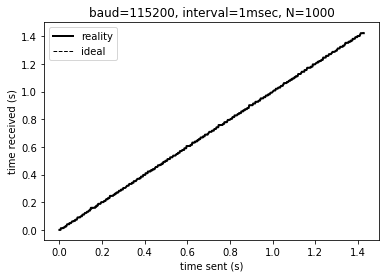

In [31]:
fig = run_test3(addr, 115200, 1)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
NLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLIOTest: ending successfully: written 528 bytes
NLNLread 528 bytes.
SerialReader: end reading...


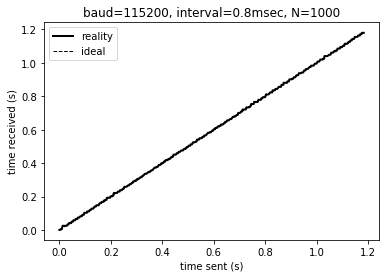

In [34]:
fig = run_test3(addr, 115200, 0.8)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
NLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLIOTest: ending successfully: written 479 bytes
NNNNread 480 bytes.
SerialReader: end reading...


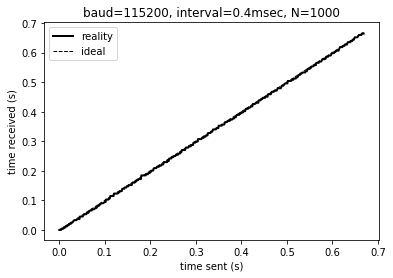

In [35]:
fig = run_test3(addr, 115200, 0.4)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...IOTest: starting writing bytes...

LNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNIOTest: ending successfully: written 500 bytes
LNLNread 500 bytes.
SerialReader: end reading...


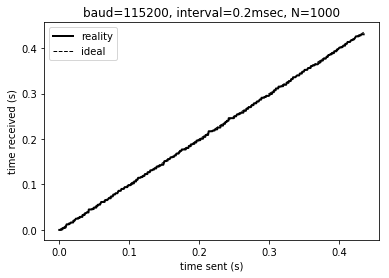

In [36]:
fig = run_test3(addr, 115200, 0.2)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
NLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLNLIOTest: ending successfully: written 508 bytes
NLNLNLNLread 508 bytes.
SerialReader: end reading...


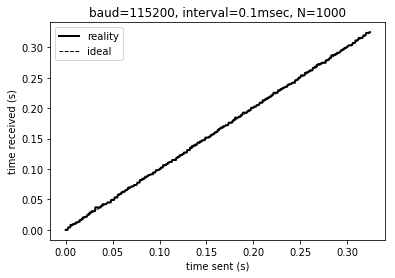

In [37]:
fig = run_test3(addr, 115200, 0.1)
plt.show()

In [40]:
# defining the state better
def decode_bits_plus(i):
    """i: 0-3 integral, returns: 'a', 'b', 'A' or 'B'"""
    if i == 0:
        return 'b'
    elif i == 1:
        return 'B'
    elif i == 2:
        return 'a'
    elif i == 3:
        return 'A'
    else:
        return '?'

def decode_compressed_plus(b):
    """b: a byte received, returns: 4 characters"""
    b = ord(b)
    ch  = decode_bits_plus((b & 0xC0)>>6)
    ch += decode_bits_plus((b & 0x20)>>4)
    ch += decode_bits_plus((b & 0x0C)>>2)
    ch += decode_bits_plus((b & 0x02))
    return ch

class IOTestPlus:
    """runs I/O test on a serial port using the specified charset.
    it takes care of redundancies.
    """
    
    def __init__(self, charset):
        self.charset_ = [ord(c) for c in charset]
        self.writer_ = None
        self.reader_ = None
        self.nread_ = None
        self.nwritten_ = None
        self.donewriting_ = threading.Event()
        self.port_ = None
        self.interval_ = 1.0
        self.number_ = 1
        self.timings_ = None
    
    def run(self, port, interval=10, N=1000):
        """runs the test with a serial object being at 'port'.
        
        Parameters
        ----------
        
        port -- serial.Serial() object that has been already created.
        
        interval -- the (nominal) interval in milliseconds at which each byte is sent.
        
        N -- the number of byets to be sent.
        
        Returns
        --------
        
        timings -- an (2, N) numpy array that has times of transmission ([0,:]) and reception ([1,:]) in it.
        """
        self.port_ = port
        self.interval_ = interval/1000
        self.number_ = N
        self.timings_ = np.empty((2,N), dtype=float); self.timings_[:] = np.nan
        self.writer_ = threading.Thread(target=self._count)
        self.nread_ = 0
        self.nwritten_ = 0
        self.donewriting_.clear()
        self.reader_ = SerialReader(port, callback=self._input)
        
        self.reader_.start()
        self.writer_.start()
        self.writer_.join()
        self.reader_.join()
        
        return self.timings_
    
    def abort(self):
        if self.reader_ is not None:
            self.reader_.signal()
            self.reader_.join()
    
    def _count(self):
        """actual method for writing to the serial port, which is called from the internal thread."""
        try:
            interval = float(self.interval_)
            number = int(self.number_)
            counter = 0
            prev = None
            
            chars = np.random.choice(self.charset_, size=number, replace=True)
            print("IOTest: starting writing bytes...", flush=True)
            while counter < number:
                time.sleep(interval)
                if chars[counter] == prev:
                    pass
                else:
                    self.port_.write(bytes(chr(chars[counter]), 'ascii'))
                    self.timings_[0,self.nwritten_] = time.time()
                    self.nwritten_ += 1
                    prev = chars[counter]
                counter += 1
            self.port_.write(b'F')
            print("IOTest: ending successfully: written {} bytes".format(self.nwritten_), flush=True)
            self.donewriting_.set()
        except:
            print_exc()
            print("IOTest: aborting.", flush=True)
            self.donewriting_.set()
    
    def _input(self, c):
        """the callback method for SerialReader."""
        if c not in (b'\r', b'\n'):
            self.timings_[1,(self.nread_):(self.nread_+4)] = time.time()
            self.nread_ += 4
            print(decode_compressed_plus(c), end='', flush=True)
            if self.donewriting_.is_set() and ((self.nread_//4) >= (self.nwritten_//4)):
                print("read {} bytes.".format(self.nread_))
                self.reader_.signal()

In [41]:
def run_test_plus(addr, baud, interval, N=1000):
    test = IOTestPlus((b'A', b'B'))
    port = serial.Serial(addr, baudrate=baud, bytesize=8, parity='N', stopbits=1, timeout=0)
    time.sleep(2)
    try:
        print(">>> " + port.readline().decode('ascii')) # waits until it sends a line back

        result = test.run(port, interval=interval, N=N)

        result -= np.nanmin(result, axis=1, keepdims=True)

        fig = plt.figure(1)
        plt.title("baud={}, interval={}msec, N={}".format(baud, interval, N))
        plt.plot(result[0,:], result[1,:], 'k-', lw=2, label="reality")
        plt.plot(result[0,:], result[0,:], 'k--', lw=1, label="ideal")
        plt.xlabel("time sent (s)")
        plt.ylabel("time received (s)")
        plt.legend()
        return fig
    except:
        print_exc()
    finally:
        port.close()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
babababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababaIOTest: ending successfully: written 486 bytes
ababread 488 bytes.
SerialReader: end reading...


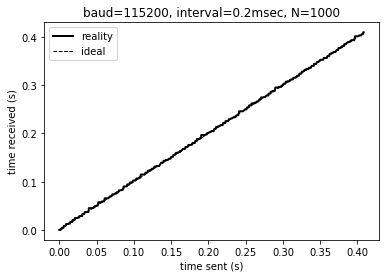

In [43]:
fig = run_test_plus(addr, 115200, 0.2)
plt.show()

>>> --Arduino ready.

SerialReader: start reading...
IOTest: starting writing bytes...
ababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababababa

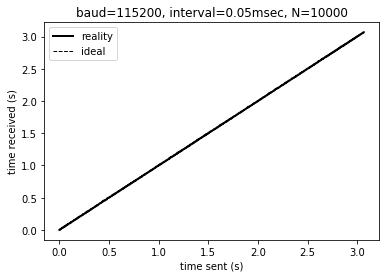

In [45]:
fig = run_test_plus(addr, 115200, 0.05, N=10000)
plt.show()